In [171]:
import numpy as np
from criticalpath import Node
import pymc as pm
import matplotlib.pyplot as plt

In [4]:
# data = [
#     {"activity": "A", "duration": 3, "predecessors": []},
#     {"activity": "B", "duration": 4, "predecessors": ["A"]},
#     {"activity": "C", "duration": 2, "predecessors": ["A"]},
#     {"activity": "D", "duration": 5, "predecessors": ["A"]},
#     {"activity": "E", "duration": 3, "predecessors": ["C", "B"]},
#     {"activity": "F", "duration": 2, "predecessors": ["D"]},
#     {"activity": "G", "duration": 3, "predecessors": ["E", "F"]},
#     {"activity": "I", "duration": 2, "predecessors": ["G"]},
# ]

In [172]:
data = [
    {"activity": "A", "true_duration": 3, "predecessors": [], 
     "true_std": 1, "guess": 8, "vagueness": 1.5},
    {"activity": "B", "true_duration": 3, "predecessors": ["A"], 
     "true_std": 0.5, "guess": 2, "vagueness": 1.3},
    {"activity": "C", "true_duration": 4, "predecessors": ["A"], 
     "true_std": 1.5, "guess": 2, "vagueness": 4},
    {"activity": "D", "true_duration": 6, "predecessors": ["A"], 
     "true_std": 2, "guess": 4, "vagueness": 2},
    {"activity": "E", "true_duration": 5, "predecessors": ["B", "C", "D"], 
     "true_std": 3, "guess": 2, "vagueness": 1.2},
]

p = Node('project')

for node in data:
    p.add(Node(node['activity'], duration=node['true_duration']))

for node in data:
    if node['predecessors'] != []:
        for predecessor in node['predecessors']:
            p.link(predecessor, node['activity'])

p.update_all()

p.duration

14

In [173]:
p.get_critical_path()

[A, D, E]

In [174]:
def simulate_normal(data:list[dict]):
    
    for idx, task in enumerate(data):
        n_prev = np.random.randint(0,5)
        prev = np.round(np.random.normal(task["true_duration"], task["true_std"], n_prev),2)
        data[idx]["prev_durations"] = prev

    return data

In [175]:
d = simulate_normal(data)

In [179]:
obs = d[0]["prev_durations"]
expert_guess = 8
vagueness = 1.7

In [180]:
obs.mean()

/tmp/ipykernel_22593/3284531684.py:1: RuntimeWarning: Mean of empty slice.
  obs.mean()


nan

In [103]:
def get_posterior_mean(obs, expert_guess, vagueness):
    with pm.Model() as task_model:

        mu = pm.Normal('mu', mu=expert_guess, sigma=vagueness)
        sigma = pm.HalfNormal('sigma', sigma=3)

        y = pm.Normal('y', mu=mu, sigma=sigma, observed=obs)

        trace = pm.sample()

    return trace.posterior["mu"].values.mean(axis=0)

In [ ]:
get_posterior_mean(obs, expert_guess, vagueness)

In [125]:
for idx, task in enumerate(d):
    posterior = get_posterior_mean(
        task["prev_durations"], 
        task["guess"], 
        task["vagueness"])
    d[idx]["posterior"] = posterior

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [162]:
durations = []
critial_paths = []

for it in range(1000):
    p = Node('project')

    for node in d:
        p.add(Node(node['activity'], duration=node['posterior'][it]))

    for node in d:
        if node['predecessors'] != []:
            for predecessor in node['predecessors']:
                p.link(predecessor, node['activity'])

    p.update_all()

    durations.append(p.duration)
    critial_paths.append([str(j) for j in p.get_critical_path()])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.hist(durations, bins=50)
plt.xlabel('Duration')
plt.ylabel('Count')
plt.title('Duration of Project')
plt.grid()

Text(0.5, 1.0, 'Critical Path Histogram')

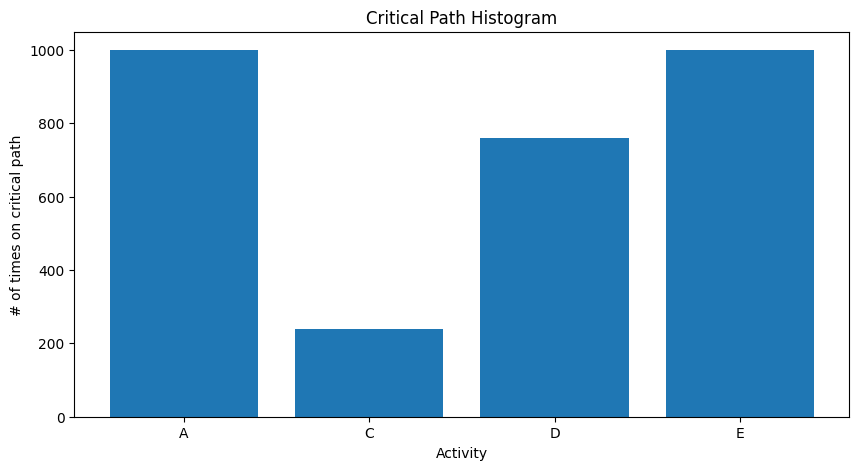

In [169]:
fig, ax = plt.subplots(figsize=(10, 5))
x, y = np.unique(critial_paths, return_counts=True)
plt.bar(x, y)
plt.xlabel('Activity')
plt.ylabel('# of times on critical path')
plt.title('Critical Path Histogram')